**OpenViSUS: read from a remote dataset**

To execute this jupyter notebook have to install: OpenViSUS, numpy, matplotlib, ipyvolume

pip3 install numpy matplotlib ipyvolume

You can do it with pip3 (which uses python3):
pip3 install OpenVisus

If the installation of OpenVisus via pip does not work you have to build it and install it yourself (see OpenViSUS README), or add your build directory to the PYTHONPATH, or in your program add it to the sys path before the import:
sys.path.append('/somepath_to_your/OpenVisus/build')


In [1]:
import sys

import gc
import sys
import math
import unittest
import string 
import unittest
import os
import matplotlib.pyplot as plt
import numpy

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import OpenVisus
from OpenVisus     import *

In [2]:
IdxModule.attach()

PythonEngine is working fine


In [3]:
tree = StringTree('<access name="Multiplex" type="multiplex"> <access name="cache"  type="disk" chmod="rw" url="file:///Users/steve/visus/cache/agricolture_time/visus.idx" /> <access name="source" type="network" chmod="r" compression="zip" />     </access>')

In [4]:
dataset=Dataset_loadDataset("http://molniya.sci.utah.edu/mod_visus?dataset=agricolture_time")
    
box=dataset.get().getBox()
access=dataset.get().createAccess(tree)
field=dataset.get().getDefaultField()
MaxH=dataset.get().getBitmask().getMaxResolution()


In [5]:
print(box.toString(), field.name, field.dtype.toString())

0 36765 0 39457 data uint8[4]


In [6]:
def time_query(t):
  
  slice_box=box.getZSlab(0,1);
  
  query=QueryPtr(Query(dataset.get(),ord('r')))
  query.get().position=Position(slice_box)
  query.get().end_resolutions.push_back(20)
  query.get().merge_mode=Query.InsertSamples
  query.get().time = t
  query.get().field = dataset.get().getDefaultField()
  dataset.get().beginQuery(query)
  #print("num samples", query.get().nsamples.innerProduct())
  if(dataset.get().executeQuery(access,query)):
    global np_data
    # convert the query result to a numpy array
    np_data = query.get().buffer.toNumPy()
    
    return True
  else:
    print("query error", query.get().getLastErrorMsg())
    return False

In [7]:
def time_query_view(t):

  if (time_query(t)):
    fig = plt.figure(figsize = (70,20))
    ax = fig.add_subplot(111)
    ax.imshow(np_data, origin='lower')
    plt.show()

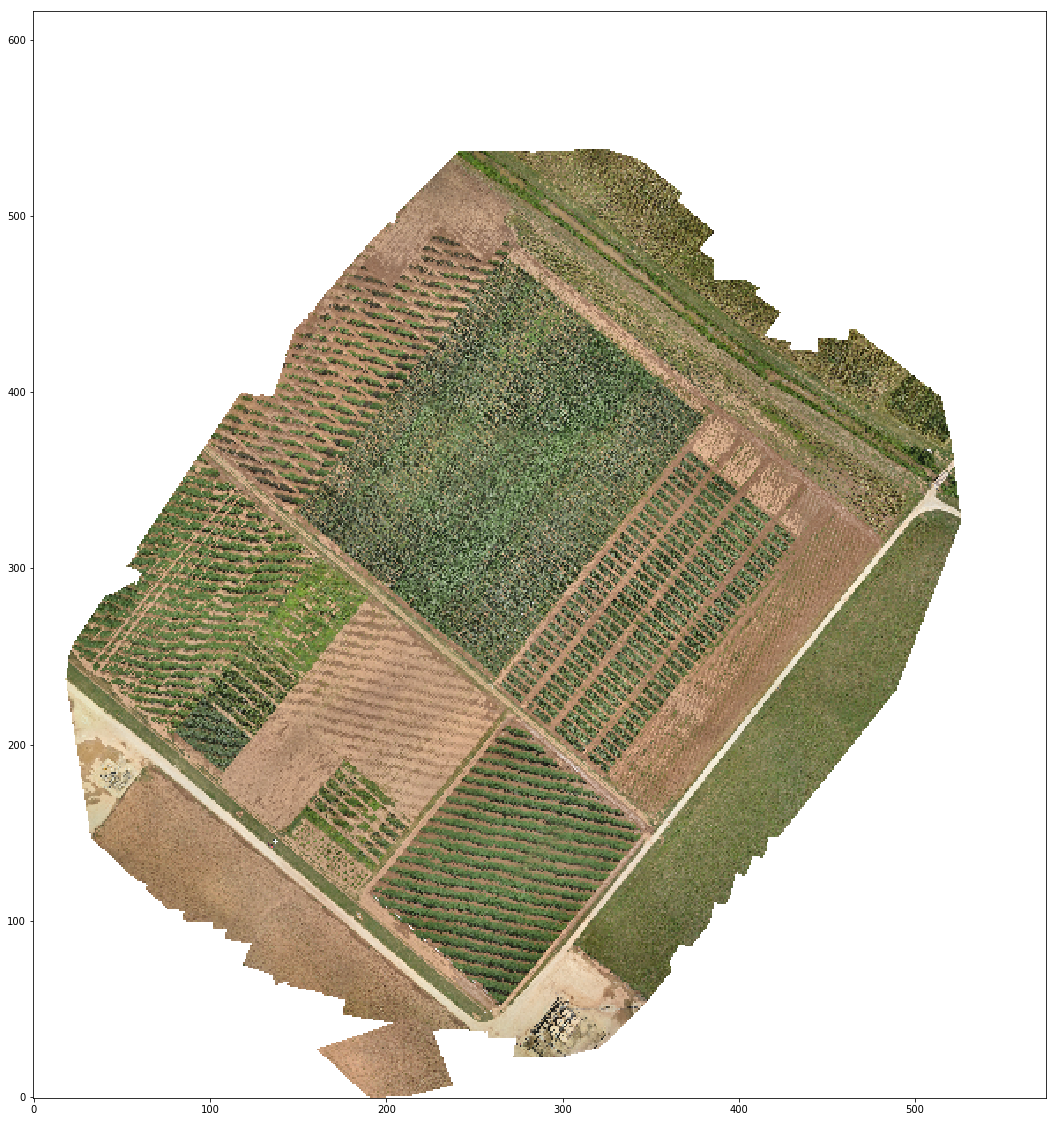

In [8]:
time_query_view(0)

In [24]:
interact(time_query_view, t=widgets.IntSlider(min=0,max=4,step=1,value=0));

interactive(children=(IntSlider(value=0, description='t', max=4), Output()), _dom_classes=('widget-interact',)…

In [9]:
def diff_query(t0, t1):
  global np_data
  global data_t0
  global data_t1
  global data_t0_grey
  global data_t1_grey
    
  if(time_query(t0)):
    data_t0 = np_data
  else: 
    return False

  if(time_query(t1)):
    data_t1 = np_data
  else:
    return False
    
  # convert to greyscale  
  data_t0_grey = numpy.dot(data_t0[...,:3], [0.299, 0.587, 0.114])
  data_t1_grey = numpy.dot(data_t1[...,:3], [0.299, 0.587, 0.114])
  return True

In [10]:
def compute_diff(t0, t1):
  global res_data
  global data_t0_grey
  global data_t1_grey

  if(diff_query(t0,t1)):
    res_data = data_t1_grey-data_t0_grey
    return True
  else:
    return False

def show_res():    
  fig = plt.figure(figsize = (70,20))
  ax = fig.add_subplot(111)
  ax.imshow(res_data, origin='lower') 
  plt.show()
    
def show_diff(t0,t1):
    if(compute_diff(t0,t1)):
      show_res()
      return True
    else:
      print("compute diff failed")
      return False

diff query done
compute diff done


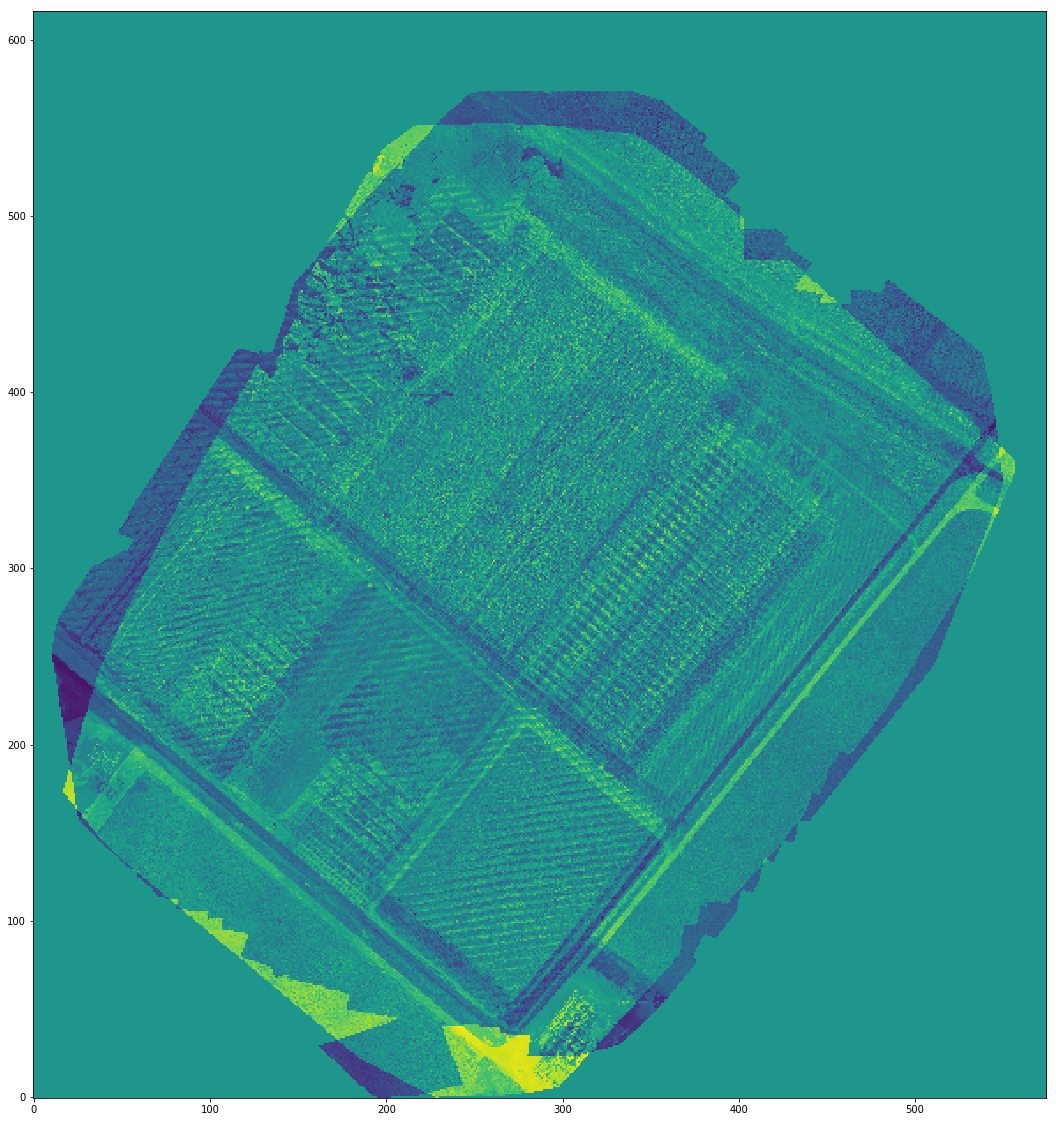

True

In [11]:
show_diff(2, 3)

In [12]:
t0_widget = widgets.IntSlider(min=0, max=6, step=1)
t1_widget = widgets.IntSlider(min=0, max=6, step=1)
interact(show_diff, t0=t0_widget, t1=t1_widget)

interactive(children=(IntSlider(value=0, description='t0', max=6), IntSlider(value=0, description='t1', max=6)…

<function __main__.show_diff(t0, t1)>

(617, 575, 3)


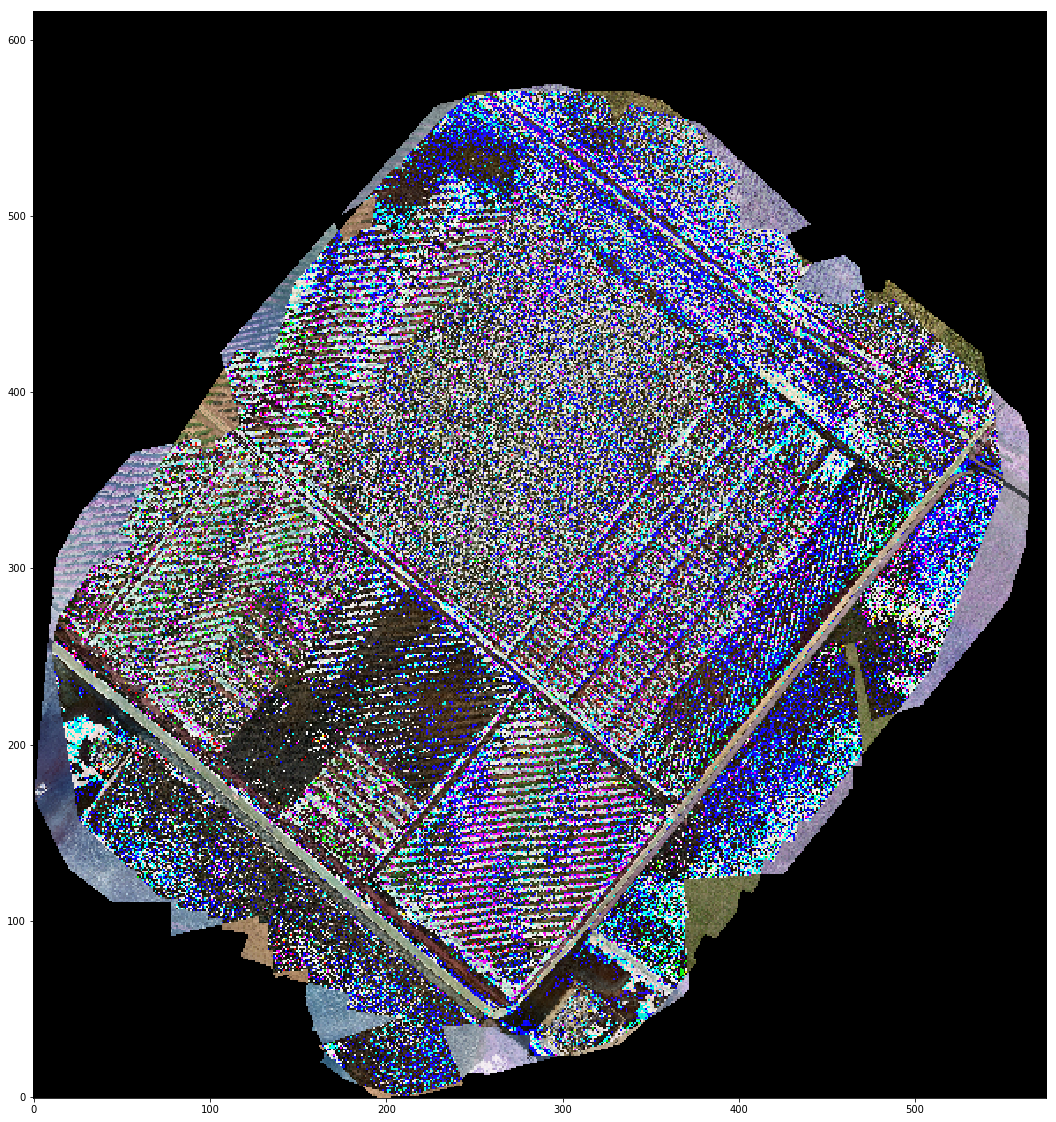

In [27]:
diff_data = data_t1-data_t0
diff_data=diff_data[:,:,0:3]
print(diff_data.shape)
fig = plt.figure(figsize = (70,20))
ax = fig.add_subplot(111)
ax.imshow(diff_data, origin='lower')
plt.show()

Making a 3D query for volume rendering

In [16]:
# select the entire dataset (2048), there are mant ways to write this selection box
slice_box=box.getZSlab(0,2048);

query=QueryPtr(Query(dataset.get(),ord('r')))
query.get().position=Position(slice_box)
query.get().end_resolutions.push_back(24)
query.get().merge_mode=Query.InsertSamples

In [17]:
# execute the query 
dataset.get().beginQuery(query)
print("num samples", query.get().nsamples.innerProduct())
dataset.get().executeQuery(access,query)

# convert the result of the query to a numpy array
np_data = query.get().buffer.toNumPy()
print(np_data.shape)

num samples 16777216
(256, 256, 256)


**Test volume rendering with iPyVolume**

In [18]:
import ipyvolume

In [19]:
ipyvolume.quickvolshow(np_data, level=[0.25, 0.75], opacity=0.03, level_width=0.1, data_min=0, data_max=255)

/usr/local/lib/python3.6/site-packages/ipyvolume/serialize.py:66: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)
